This Chapter of the book is all about Fully Connected Networks. First, a linear regression Model is build. Second, a logistic regression is build.

In [8]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm # imports command line progressbar
from torch.utils.data import * 
import matplotlib.pyplot as plt
# from idlmam import * # github package to the book


In [2]:
def train_simple_network(model, loss_func, training_loader, epochs=20, device='cpu'):
    # training_loader provides us with a batched dataset, which omits having the dataset stored in memory all the time.
    # initialize optimizer with model params
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    # move model to devide
    model.to(device)

    # do the training
    for epoch in tqdm(range(epochs), desc = "Epoch"):
        model = model.train() # unfreeze weights and put model in training model
        running_loss = 0.0

        for inputs, labels in tqdm(training_loader, desc="Batch", leave=False):
            inputs = inputs.to(device)
            labels = inputs.to(device)
            # inputs = moveTo(inputs, device) # function from the inside deep learning package
            # labels = moveTo(labels, device)

            optimizer.zero_grad()
            
            y_hat = model(inputs)
            loss = loss_func(y_hat, labels)
            loss.backward() # compute gradients
            
            # adjust params
            optimizer.step()

            running_loss += loss.item()


The above code is a simple training loop, the next thing we need to do in order to construct a small neural network for a regression problem is to create a sample dataset. The below variables will be used as our example dataset in the following. We will wrap a dataset object around it.

<AxesSubplot:>

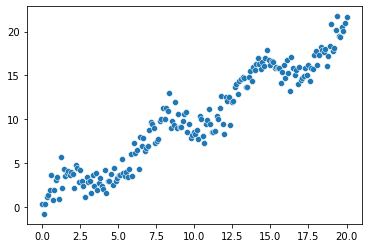

In [3]:
X = np.linspace(0,20, num=200)
y = X + np.sin(X)*2 + np.random.normal(size=X.shape) # linear + nonliner + random part

sns.scatterplot(x=X, y=y)

As a reminder: To create a ``Dataset`` object, we need to define the magic methots ``__len__``, ``__getindex__`` and the constructor ``__init__``.
The ``Dataset`` object controlls how to get a specific datapoint. The ``DataLoader`` optimizes the datapipeline in such a way that the GPU is as busy as possible during training. Hence, the dataloader fetches the data from the dataset.

In addition, we are reshaping the numpy array when it reaches the system with the command `.reshape(-1,1)`. This simply means, that the first dimension should be infered from the input length. In addition, a second dimension of size 1 is added.
For a more detailed explanation, see the book on side 38.
`reshape()` works in the way that is simply reshapes a given data structure. For this, we need to specify all but one dimension, where the left over dimension (we don't want to specify) is denoted with '-1'. By adding more arguments to the function, we add more dimensions to the tensor. 

*Example:* Given a numpy array x of 6 values with only one dimension, we can use ``x.reshape(6)`` or ``x.reshape(-1)`` to get the same value. When using ``x.reshape(-1,3)`` We say that the second dimension (width of tensor) should be 3 and due to '-1' numpy infers that the height of the 2d tensor should be 2.


In [4]:
class regressionDataset(Dataset):
    def __init__(self,X,y):
        super(regressionDataset, self).__init__()
        self.X = X.reshape(-1,1)
        self.y = y.reshape(-1,1)

    def __getitem__(self, index):
        "This magic method returns a sample and the label for the given index. The returned values must be a torch.tensor"
        input = torch.tensor(self.X[index,:], dtype=torch.float32)
        label = torch.tensor(self.y[index], dtype=torch.float32)
        return input, label
    
    def __len__(self):
        "Returns number of samples"
        return self.X.shape[0]

In [5]:
data = regressionDataset(X,y)
print(len(data)) # works
print(data[2]) # works

200
(tensor([0.2010]), tensor([0.3528]))


The created dataset can now be used by a ``DataLoader``. The dataloader makes passing data to the model more efficient and hence is the preferred way for training.

In [6]:
training_loader = DataLoader(regressionDataset(X,y), shuffle=True)

Now, we have created the needed data and can create and train our model. Therefore, we will use a simple linear layer which corresponds to a vector matrix multiplication of the input, wehereas the weights correspond to the coefficients. In addition, a bias term is added, which allows the model to shift the solution.

In pytorch, the building blocks are defined in modules such as ``torch.nn.Linear``.
Each module has a ``forward()`` method which defines how data passes through the layer (i.e. takes input and produces output) and also a ``backward()`` method which defines how the gradient is calculated. Usually, pytorch takes care of the latter one.

Regarding the loss: The absolute difference is taken, to omit a negative loss, which would lead the model to get worse since a negative loss would further decrease the loss (loss function should be bounded from below by 0). An alternative would be the MSE.


In [7]:
in_features = 1
out_features = 1
model = nn.Linear(in_features, out_features)
loss_func = nn.MSELoss()

device = torch.device("cuda")
train_simple_network(model, loss_func,training_loader,20, device="cpu")


Epoch: 100%|██████████| 20/20 [00:01<00:00, 18.43it/s]


We can see that the model trained. We will proceed by testing the predictions, for this we use the `torch.no_grad()` context, which tells pytorch that everything what is done within this context, no gradients should be calculated.

<AxesSubplot:>

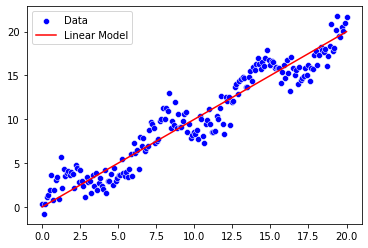

In [11]:
with torch.no_grad():
    y_pred = model(torch.tensor(X.reshape(-1,1), device="cpu", dtype=torch.float32)).numpy()
sns.scatterplot(x=X,y=y, color ="blue", label="Data")
sns.lineplot(x=X, y=y_pred.ravel(), color="red", label="Linear Model") # ravel() used for flattening the array. because numpy(n,1) shape

In [54]:
# building a more complicated network with the sequential api
model = nn.Sequential(nn.Linear(1,10),
                      nn.Linear(10,1))
train_simple_network(model, loss_func, training_loader, device="cuda")

Epoch: 100%|██████████| 20/20 [00:03<00:00,  6.47it/s]


In [53]:
with torch.no_grad():
    y_pred = model(torch.tensor(X.reshape(-1,1), device="cpu", dtype=torch.float32)).numpy()
sns.scatterplot(x=X,y=y, color ="blue", label="Data")
sns.lineplot(x=X, y=y_pred.ravel(), color="red", label="Linear Model")

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_addmm)

We can see that the result is nearly identical to before! This is because stacking linear layers on top of each other is nothing else than just multipyling matrices with each other and hence, this still results in a matrix, but still remains a linear transformation. Therefore in order to introduce non-linearities and allow the model to learn non-linear patterns, we introduce (non-linear) activation functions between the layer. Without these, the linear layer is just a projection into a smaller or larger space. Without these non-linear activation functions, stacking matrices on top of each other is equivalent to just on linear layer.

In [57]:
model = nn.Sequential(
    nn.Linear(1,10),
    nn.Tanh(),
    nn.Linear(10,1)
)
train_simple_network(model, loss_func, training_loader, epochs=100, device="cuda")

Epoch: 100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


<AxesSubplot:>

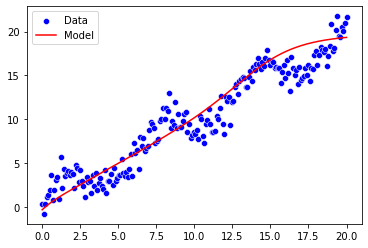

In [58]:
with torch.no_grad():
    y_pred = model(torch.tensor(X.reshape(-1,1), device="cuda", dtype=torch.float32)).cpu().numpy()
sns.scatterplot(x=X,y=y, color ="blue", label="Data")
sns.lineplot(x=X, y=y_pred.ravel(), color="red", label="Model")

Introducing the activation functions leads to a nonlinear model! However getting the above fit also needed more epochs (around 100 instead of 20). 

## Classification Problems
In this section we will focus on a classification problem!

<AxesSubplot:>

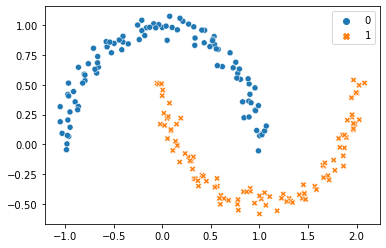

In [3]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, noise=0.05)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y)

We have two inputs and two classes \{0,1\}

In [4]:
classification_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)
)
training_loader = DataLoader(classification_dataset)

We will first look at a linear classifier, which uses a linear discrimination boundary to seperate the classes. It has a linear decision boundary. Afterwards, we will use non linear activation functions to create non-linear decision boundaries.

In [5]:
in_features=2
out_features=2
model = nn.Linear(in_features, out_features)

In order to do classification, we need to use another, classification specific loss function. To do the classification on the data we need to components, the softmax and the cross entropy. The softmax function is used to convert logits to class probabilities. The cross entropy is used to compare these probabilites to the true classes. These two components combined is often called the cross entropy loss.

To get the class prediction $\hat{y}$, we can use the argmax function, since applying the argmax to logits or probabilities, leads to the same result. However, we also want to get probabilites for each prediction. It is also important that all probabilites sum up to 1. 

*Why is it called softmax?* Because if we take the dot product between the initial logits vector and the softmax vector it is approximatly equal to the maximum value in the logits vector, however, it can also be less. It will only be equal to the largest number in the logits vector, if all values are identical.

Cross-entropy is a tool to tell how differnt two distributions are (not a proper distance measure, since it is not symmetric). It tells us how much information it takes us to encode something if we used distribution q but the actual distribution is p.

Putting both tools together, we get the cross entropy loss. 

$\rightarrow$ Now we can train our classifcation network.

In [10]:
loss_func = nn.CrossEntropyLoss()
train_simple_network(model, loss_func, training_loader, epochs=150)

Epoch: 100%|██████████| 150/150 [00:28<00:00,  5.25it/s]


Next, we can use the provided function from the book to visualize the results.

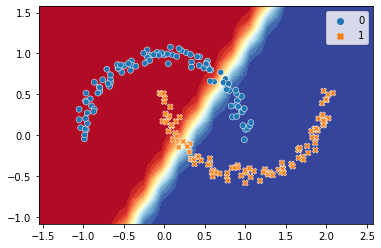

In [20]:
def visualize2DSoftmax(X, y, model, title=None):

    x_min = np.min(X[:, 0])-0.5
    x_max = np.max(X[:, 0])+0.5
    y_min = np.min(X[:, 1])-0.5
    y_max = np.max(X[:, 1])+0.5
    xv, yv = np.meshgrid(np.linspace(x_min, x_max, num=20),
                        np.linspace(y_min, y_max, num=20), indexing='ij')
    xy_v = np.hstack((xv.reshape(-1, 1), yv.reshape(-1, 1)))
    with torch.no_grad():
        logits = model(torch.tensor(xy_v, dtype=torch.float32))
        y_hat = F.softmax(logits, dim=1).numpy()
        
    cs = plt.contourf(xv, yv, y_hat[:, 0].reshape(20, 20),
                  levels=np.linspace(0, 1, num=20), cmap=plt.cm.RdYlBu)
    ax = plt.gca()
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, style=y, ax=ax)
    if title is not None:
        ax.set_title(title)

visualize2DSoftmax(X, y, model)


Note that both red and blue contour is inverted.
Next, we add an activation function between hidden layers to get a non linear decisio boundary.

In [24]:
model = nn.Sequential(
    nn.Linear(2,30),
    nn.Tanh(),
    nn.Linear(30,30),
    nn.Tanh(),
    nn.Linear(30,2)
)
train_simple_network(model, loss_func, training_loader,epochs=350)

Epoch: 100%|██████████| 350/350 [01:39<00:00,  3.50it/s]


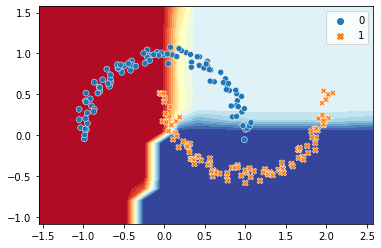

In [25]:
visualize2DSoftmax(X,y, model)

We can see that it now takes more time to train the network, but adding a non linear activation function also leads to a non-linear decision boundary. Hence, we are able to improve the separation.

As a last note it can be said, that using cross entropy is kind of a proxy for how bad the model is doing in a classification setting, since we cannot define errors in a differentiable way in the classification setting. For this, we can use metrics, which tell us in the test set how bad the model is doing.

In [27]:
# stopped at 2.4. Better training code.
# the following training function also includes a train and test split evaluation.
# note that model.train() and model.eval() have an effect on some specific layers but not on the gradients,
# that is the reason why we are using the torch.no_grad() context
from sklearn.metrics import accuracy_score, f1_score
from idlmam import train_simple_network

X_train, y_train = make_moons(n_samples=8000, noise=0.4)
X_test, y_test = make_moons(n_samples=200, noise=0.4)
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                             torch.tensor(y_test, dtype=torch.long))

training_loader = DataLoader(train_dataset, shuffle=True)
testing_loader = DataLoader(test_dataset)

model = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2),
)
results_pd = train_simple_network(model, loss_func, training_loader, epochs=5, test_loader=testing_loader,
                                  checkpoint_file='model.pt', score_funcs={'Acc': accuracy_score, 'F1': f1_score})


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/8000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/8000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/8000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/8000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/8000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

To load the previously defined model, we need to define a model which has the same architecture as the saved model.

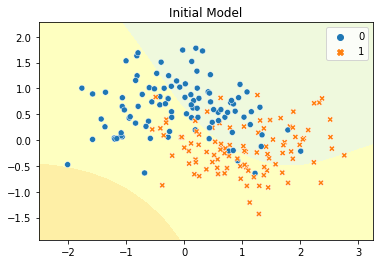

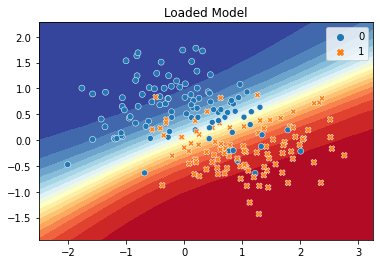

In [32]:
model_new = nn.Sequential(
nn.Linear(2, 30),
nn.Tanh(),
nn.Linear(30, 30),
nn.Tanh(),
nn.Linear(30, 2),)

# visualize the test data with the initial model (without training)
# weights are random values
visualize2DSoftmax(X_test, y_test, model_new, title="Initial Model")
plt.show()

# load the checkpoint data of trained model and map it to a specified device
checkpoint_dict = torch.load('model.pt', map_location="cpu")
# load the weights to the model
model_new.load_state_dict(checkpoint_dict['model_state_dict'])
# if we want to contine training, we also need to load the optimizer with
# optimizer.load_state_dict(checkpoint[‘optimizer_state_dict'])

# visualize the predictions for the trained model
# weights are trained
visualize2DSoftmax(X_test, y_test, model_new, title="Loaded Model")
plt.show()

In [33]:
results_pd.head()

,epoch,total time,train loss,test loss,train Acc,test Acc,train F1,test F1
0,0,2.804822,0.416530,0.366996,0.826000,0.860,0.827893,0.858586
1,1,5.569443,0.384463,0.365560,0.833000,0.855,0.833541,0.852792
2,2,8.485912,0.383411,0.364761,0.833375,0.850,0.833562,0.850000
3,3,11.300420,0.382280,0.363287,0.833500,0.855,0.833832,0.852792
4,4,14.616186,0.381495,0.363036,0.836000,0.855,0.836000,0.851282


<AxesSubplot:xlabel='epoch', ylabel='train Acc'>

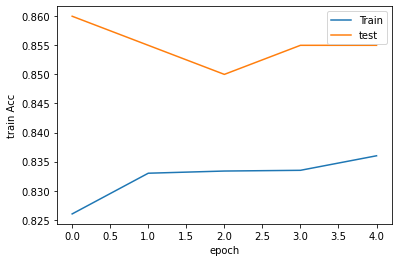

In [34]:
sns.lineplot(x="epoch", y="train Acc", data=results_pd, label="Train")
sns.lineplot(x="epoch", y="test Acc", data=results_pd, label="test")

## Choosing the batch size
**The batch size controlls how many samples to work through before updating the weights.**
Therefore when doing GD we need to sum over all data points and get an exact gradient for the update. This leads to the fact that each epoch we only compute one update and we will always move into the right direction.

In contrast, the SGD (stochastic gradient descent) does $\frac{n}{m}$ update steps per epoch where $m$ is the batch size. SGD computes the gradient on a sub sample of size $m$, which leads to a noisier gradient compared to GD (the right gradient direction is not guaranteed). However, this noisier update is often sufficient and a good approximation. Ultimately the SGD leads to more (noisier) update steps per epoch compared to the GD, which leads to better results in practice.
$\newline \rightarrow$ $\frac{n}{m}$ steps (SGD) per epoch bring greater improvement than 1 step (GD)

In practice, the batch size $m$ is used such that it fits right into the memory of the GPU.